In [4]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel
import os

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import saqqara
from simulator import LISA_AET
import glob
import torch
import swyft
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from pytorch_lightning import loggers as pl_loggers

DATA_DIR = "./simulations/"
Z_FILES = glob.glob(DATA_DIR + "/z_*.npy")
Z_FILES = sorted(Z_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
DATA_FILES = glob.glob(DATA_DIR + "/cg_data_*.npy")
DATA_FILES = sorted(DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))

In [6]:
# Check all names match
for idx in range(len(Z_FILES)):
    assert (
        Z_FILES[idx].split("_")[-1].split(".")[0]
        == DATA_FILES[idx].split("_")[-1].split(".")[0]
    )

In [7]:
# Compute total number of simulations
n_simulations = len(Z_FILES) * 128
print(f"Total number of simulations: {n_simulations}")

# Get data shapes
z_shape = np.load(Z_FILES[0]).shape[1:]
data_shape = np.load(DATA_FILES[0]).shape[1:]
print(f"z shape: {z_shape}")
print(f"data shape: {data_shape}")

config = saqqara.load_settings("default_config.yaml")
sim = LISA_AET(config)

Total number of simulations: 1000192
z shape: (4,)
data shape: (945, 3)
Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [8]:
z_dataset = saqqara.NPYDataset(file_paths=Z_FILES)
data_dataset = saqqara.NPYDataset(file_paths=DATA_FILES)
training_dataset = saqqara.TrainingDataset(z_store=z_dataset, data_store=data_dataset)

In [9]:
# Dataset properties
print("Training dataset properties:")
print("length:", len(training_dataset))
print("z shape:", training_dataset["z"][0].shape)
print("data shape:", training_dataset["data"][0].shape)

Training dataset properties:
length: 1000192
z shape: torch.Size([4])
data shape: torch.Size([945, 3])


/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/saqqara/data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(data).float()


In [10]:
def setup_dataloaders(
    dataset,
    total_size=None,
    train_fraction=0.8,
    val_fraction=0.2,
    num_workers=0,
    batch_size=64,
):
    if total_size is None:
        total_size = len(dataset)
    indices = list(range(len(dataset)))
    train_idx, val_idx = int(np.floor(train_fraction * total_size)), int(
        np.floor((train_fraction + val_fraction) * total_size)
    )
    train_indices, val_indices = indices[:train_idx], indices[train_idx:val_idx]
    # train_sampler, val_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    train_sampler, val_sampler = SequentialSampler(train_indices), SequentialSampler(
        val_indices
    )
    train_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=train_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    val_dataloader = DataLoader(
        dataset=dataset,
        drop_last=True,
        sampler=val_sampler,
        num_workers=int(num_workers),
        batch_size=int(batch_size),
    )
    return train_dataloader, val_dataloader

In [11]:
total_size = 1_000_000
learning_rate = 1e-5
batch_size = 2048
train_dl, val_dl = setup_dataloaders(training_dataset, total_size=total_size, num_workers=10, batch_size=batch_size)

In [12]:
from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel

class InferenceNetwork(swyft.SwyftModule, swyft.AdamWReduceLROnPlateau):
    def __init__(self, sim=None, learning_rate=1e-5):
        super().__init__()
        self.sim = sim
        self.learning_rate = learning_rate
        self.early_stopping_patience = 100
        self.num_feat_param = 3  # Number of channels
        self.num_params = 2
        self.npts = sim.coarse_grained_f.shape[0]
        #self.npts = 650
        self.nl_AA = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_AA_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_EE_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_TT_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.resnet = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.resnet_no_log = ResidualNetWithChannel(
            channels=3,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )
        self.fc_AA = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_EE = torch.nn.Linear(self.npts, sim.nparams)
        self.fc_TT = torch.nn.Linear(self.npts, sim.nparams)
        self.marginals = self.get_marginals(self.num_params)
        self.lrs1d = swyft.LogRatioEstimator_1dim(
            #num_features=self.num_feat_param,
            num_features=2 * self.num_feat_param * self.num_params,
            num_params=self.num_params,
            varnames="z",
            num_blocks=3,
            hidden_features=64,
            dropout=0.1,
        )
        self.lrs2d = swyft.LogRatioEstimator_Ndim(
            #num_features=2 * self.num_feat_param,
            num_features=2 * self.num_feat_param * self.num_params,
            marginals=self.marginals,
            num_blocks=3,
            hidden_features=64,
            varnames="z",
            dropout=0.1,
        )

    def forward(self, A, B):
        log_data = torch.log(A["data"])
        # reshape to (batch, num_channels, num_freqs)
        log_data = log_data.transpose(1, 2)
        norm_AA = self.nl_AA(log_data[..., 0, :])
        norm_EE = self.nl_EE(log_data[..., 1, :])
        norm_TT = self.nl_TT(log_data[..., 2, :])

        full_data = torch.stack([norm_AA, norm_EE, norm_TT], dim=-2)
        no_log_data = torch.exp(full_data)
        norm_AA_nolog = self.nl_AA_nolog(no_log_data[..., 0, :])
        norm_EE_nolog = self.nl_EE_nolog(no_log_data[..., 1, :])
        norm_TT_nolog = self.nl_TT_nolog(no_log_data[..., 2, :])
        no_log_data = torch.stack([norm_AA_nolog, norm_EE_nolog, norm_TT_nolog], dim=-2)

        compression = self.resnet(full_data)
        no_log_compression = self.resnet_no_log(no_log_data)
        s1 = compression.reshape(-1, self.num_params * self.num_feat_param)
        s2 = no_log_compression.reshape(-1, self.num_params * self.num_feat_param)
        s = torch.cat((s1, s2), dim=1)
        # lrs1d = self.lrs1d(s, B["z"][:, :2])
        lrs2d = self.lrs2d(s, B["z"][:, :2])
        #return lrs1d, lrs2d
        return lrs2d

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j > i:
                    marginals.append((i, j))
        return tuple(marginals)

In [14]:
# logger = pl_loggers.WandbLogger(
#     offline=False,
#     name=f"conv_net_{total_size}_{learning_rate}_{batch_size}",
#     project="saqqara",
#     entity="j-b-g-alvey",
#     log_model="all",
#     config=config,
# )
device = "gpu" if torch.cuda.is_available() else "cpu"
trainer = swyft.SwyftTrainer(accelerator=device, max_epochs=100, logger=None)
network = InferenceNetwork(sim=sim)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
ckpt = "./saqqara/ae6mjehp/checkpoints/epoch=96-step=37830.ckpt" # single target training, amortised (28/5)

In [16]:
def load_network_state(network, checkpoint):
    state_dict = torch.load(checkpoint)['state_dict']
    network.load_state_dict(state_dict)
    return network

In [17]:
nn = load_network_state(network, ckpt)

In [18]:
prior_samples = sim.sample(100_000, targets=["z"])

100%|██████████| 100000/100000 [00:01<00:00, 82535.27it/s]


In [19]:
observation = sim.sample(conditions={"z": np.array([-11.0, 0.0, 3., 15.])})
observation["data"] = torch.tensor(observation["coarse_grained_data"])
dict_keys = list(observation.keys())
for k in dict_keys:
    if k not in ["z", "data"]:
        observation.pop(k)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


In [20]:
logratios = trainer.infer(network, observation, prior_samples, batch_size=1024)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/98 [00:00<?, ?it/s]

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 98/98 [00:01<00:00, 93.85it/s]


In [31]:
logratios_list_11 = []
bounds_list_11 = []
import tqdm
for _ in tqdm.tqdm(range(100)):
    observation = sim.sample(conditions={"z": np.array([-11., 0.0, np.random.normal(3., 0.6), np.random.normal(15., 3.)])})
    observation["data"] = torch.tensor(observation["coarse_grained_data"])
    dict_keys = list(observation.keys())
    for k in dict_keys:
        if k not in ["z", "data"]:
            observation.pop(k) 
    logratios = trainer.infer(network, observation, prior_samples, batch_size=1024)  
    logratios_list_11.append(logratios) 
    bounds_list_11.append(swyft.get_rect_bounds(logratios, threshold=1e-5))

  0%|          | 0/100 [00:00<?, ?it/s]/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precis

Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 129.67it/s]


  1%|          | 1/100 [00:02<04:14,  2.57s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 140.84it/s]

  2%|▏         | 2/100 [00:05<04:04,  2.49s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 150.08it/s]


  3%|▎         | 3/100 [00:07<03:59,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 166.01it/s]


  4%|▍         | 4/100 [00:09<03:52,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 167.33it/s]


  5%|▌         | 5/100 [00:12<03:47,  2.39s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 142.27it/s]

  6%|▌         | 6/100 [00:14<03:47,  2.42s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 165.95it/s]


  7%|▋         | 7/100 [00:16<03:43,  2.41s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 140.59it/s]


  8%|▊         | 8/100 [00:19<03:42,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 163.36it/s]


  9%|▉         | 9/100 [00:21<03:38,  2.40s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 131.36it/s]

 10%|█         | 10/100 [00:24<03:38,  2.43s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 134.52it/s]


 11%|█         | 11/100 [00:26<03:38,  2.45s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 130.53it/s]

 12%|█▏        | 12/100 [00:29<03:38,  2.48s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 163.07it/s]


 13%|█▎        | 13/100 [00:31<03:32,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 133.49it/s]


 14%|█▍        | 14/100 [00:34<03:32,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 164.15it/s]


 15%|█▌        | 15/100 [00:36<03:26,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 132.79it/s]


 16%|█▌        | 16/100 [00:39<03:26,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 139.61it/s]


 17%|█▋        | 17/100 [00:41<03:24,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 155.72it/s]


 18%|█▊        | 18/100 [00:43<03:19,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 149.56it/s]


 19%|█▉        | 19/100 [00:46<03:16,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 136.59it/s]


 20%|██        | 20/100 [00:48<03:15,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 167.49it/s]


 21%|██        | 21/100 [00:51<03:11,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 121.52it/s]


 22%|██▏       | 22/100 [00:53<03:12,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 127.71it/s]

 23%|██▎       | 23/100 [00:56<03:11,  2.48s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 134.21it/s]


 24%|██▍       | 24/100 [00:58<03:08,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 120.11it/s]


 25%|██▌       | 25/100 [01:01<03:08,  2.51s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 140.70it/s]


 26%|██▌       | 26/100 [01:03<03:05,  2.50s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 155.58it/s]


 27%|██▋       | 27/100 [01:06<03:00,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 119.44it/s]


 28%|██▊       | 28/100 [01:08<03:01,  2.52s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 168.34it/s]


 29%|██▉       | 29/100 [01:11<02:55,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 167.11it/s]


 30%|███       | 30/100 [01:13<02:50,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 172.36it/s]


 31%|███       | 31/100 [01:15<02:45,  2.39s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 135.44it/s]


 32%|███▏      | 32/100 [01:18<02:45,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 145.98it/s]


 33%|███▎      | 33/100 [01:20<02:43,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 156.73it/s]


 34%|███▍      | 34/100 [01:23<02:39,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 139.48it/s]


 35%|███▌      | 35/100 [01:25<02:37,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 159.56it/s]


 36%|███▌      | 36/100 [01:28<02:34,  2.41s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 138.40it/s]


 37%|███▋      | 37/100 [01:30<02:33,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 161.46it/s]


 38%|███▊      | 38/100 [01:32<02:29,  2.41s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 158.00it/s]


 39%|███▉      | 39/100 [01:35<02:26,  2.40s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 167.85it/s]


 40%|████      | 40/100 [01:37<02:23,  2.39s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 163.60it/s]


 41%|████      | 41/100 [01:39<02:20,  2.38s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 116.59it/s]


 42%|████▏     | 42/100 [01:42<02:21,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 130.98it/s]

 43%|████▎     | 43/100 [01:45<02:20,  2.47s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 136.90it/s]


 44%|████▍     | 44/100 [01:47<02:17,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 133.72it/s]


 45%|████▌     | 45/100 [01:50<02:16,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 150.93it/s]


 46%|████▌     | 46/100 [01:52<02:12,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 155.85it/s]


 47%|████▋     | 47/100 [01:54<02:09,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 103.52it/s]


 48%|████▊     | 48/100 [01:57<02:11,  2.53s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 143.31it/s]


 49%|████▉     | 49/100 [02:00<02:08,  2.51s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 157.04it/s]


 50%|█████     | 50/100 [02:02<02:03,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 137.22it/s]


 51%|█████     | 51/100 [02:04<02:01,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 142.37it/s]


 52%|█████▏    | 52/100 [02:07<01:59,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 147.06it/s]

 53%|█████▎    | 53/100 [02:09<01:55,  2.46s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 146.21it/s]


 54%|█████▍    | 54/100 [02:12<01:53,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 162.86it/s]


 55%|█████▌    | 55/100 [02:14<01:49,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 164.11it/s]


 56%|█████▌    | 56/100 [02:17<01:46,  2.41s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 159.44it/s]


 57%|█████▋    | 57/100 [02:19<01:43,  2.40s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 164.41it/s]


 58%|█████▊    | 58/100 [02:21<01:40,  2.39s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 126.59it/s]

 59%|█████▉    | 59/100 [02:24<01:39,  2.43s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 152.56it/s]

 60%|██████    | 60/100 [02:26<01:37,  2.44s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 169.94it/s]


 61%|██████    | 61/100 [02:29<01:33,  2.41s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 136.23it/s]


 62%|██████▏   | 62/100 [02:31<01:32,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 153.02it/s]


 63%|██████▎   | 63/100 [02:33<01:29,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 145.49it/s]


 64%|██████▍   | 64/100 [02:36<01:27,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 149.82it/s]


 65%|██████▌   | 65/100 [02:38<01:25,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 129.31it/s]


 66%|██████▌   | 66/100 [02:41<01:23,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 165.11it/s]


 67%|██████▋   | 67/100 [02:43<01:20,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 131.17it/s]


 68%|██████▊   | 68/100 [02:46<01:19,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 125.10it/s]


 69%|██████▉   | 69/100 [02:48<01:17,  2.51s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 129.82it/s]


 70%|███████   | 70/100 [02:51<01:15,  2.52s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 123.24it/s]

 71%|███████   | 71/100 [02:54<01:13,  2.53s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 128.16it/s]


 72%|███████▏  | 72/100 [02:56<01:10,  2.52s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 128.36it/s]


 73%|███████▎  | 73/100 [02:59<01:08,  2.53s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 130.88it/s]


 74%|███████▍  | 74/100 [03:01<01:05,  2.52s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 140.64it/s]


 75%|███████▌  | 75/100 [03:04<01:02,  2.51s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 136.29it/s]


 76%|███████▌  | 76/100 [03:06<00:59,  2.49s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 154.85it/s]


 77%|███████▋  | 77/100 [03:08<00:56,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 149.01it/s]


 78%|███████▊  | 78/100 [03:11<00:53,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 153.77it/s]


 79%|███████▉  | 79/100 [03:13<00:50,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 146.80it/s]


 80%|████████  | 80/100 [03:16<00:48,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 144.12it/s]


 81%|████████  | 81/100 [03:18<00:46,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 124.16it/s]


 82%|████████▏ | 82/100 [03:21<00:44,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 132.33it/s]


 83%|████████▎ | 83/100 [03:23<00:42,  2.51s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 138.08it/s]


 84%|████████▍ | 84/100 [03:26<00:40,  2.50s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 168.34it/s]


 85%|████████▌ | 85/100 [03:28<00:36,  2.45s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 152.13it/s]


 86%|████████▌ | 86/100 [03:30<00:34,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 156.03it/s]


 87%|████████▋ | 87/100 [03:33<00:31,  2.42s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 165.59it/s]


 88%|████████▊ | 88/100 [03:35<00:28,  2.40s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 123.03it/s]


 89%|████████▉ | 89/100 [03:38<00:27,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 134.25it/s]


 90%|█████████ | 90/100 [03:40<00:24,  2.47s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 166.13it/s]


 91%|█████████ | 91/100 [03:43<00:21,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 143.97it/s]


 92%|█████████▏| 92/100 [03:45<00:19,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 155.49it/s]


 93%|█████████▎| 93/100 [03:47<00:16,  2.43s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 121.84it/s]

 94%|█████████▍| 94/100 [03:50<00:14,  2.48s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 144.39it/s]


 95%|█████████▌| 95/100 [03:53<00:12,  2.48s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 143.76it/s]


 96%|█████████▌| 96/100 [03:55<00:09,  2.46s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 153.64it/s]


 97%|█████████▋| 97/100 [03:57<00:07,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 146.26it/s]


 98%|█████████▊| 98/100 [04:00<00:04,  2.44s/it]The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 132.50it/s]

 99%|█████████▉| 99/100 [04:02<00:02,  2.46s/it]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 98/98 [00:00<00:00, 131.62it/s]


100%|██████████| 100/100 [04:05<00:00,  2.45s/it]


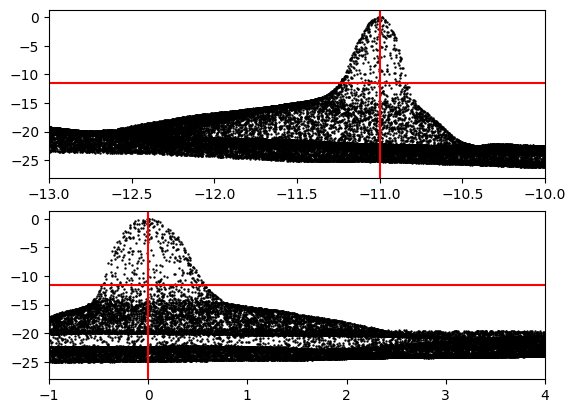

In [32]:
ax = plt.subplot(2, 1, 1)
plt.scatter(logratios.params[::2, 0, 0], logratios.logratios[::2, 0] - torch.max(logratios.logratios[::2, 0]), s=0.5, c='k')
plt.xlim(-13, -10)
plt.axvline(-11.0, c="r")
plt.axhline(np.log(1e-5), c='r')
ax = plt.subplot(2, 1, 2)
plt.scatter(logratios.params[::2, 0, 1], logratios.logratios[::2, 0] - torch.max(logratios.logratios[::2, 0]), s=0.5, c='k')
plt.xlim(-1, 4)
plt.axhline(np.log(1e-5), c='r')
plt.axvline(0.0, c="r")

In [36]:
bounds_list_11[0].bounds.shape

torch.Size([1, 2, 2])

In [37]:
min_a_bds_11 = np.array([float(bounds_list_11[k].bounds[0, 0, 0]) for k in range(100)])
max_a_bds_11 = np.array([float(bounds_list_11[k].bounds[0, 0, 1]) for k in range(100)])
min_g_bds_11 = np.array([float(bounds_list_11[k].bounds[0, 1, 0]) for k in range(100)])
max_g_bds_11 = np.array([float(bounds_list_11[k].bounds[0, 1, 1]) for k in range(100)])
cons_min_a_11, cons_max_a_11, cons_min_g_11, cons_max_g_11, = np.min(min_a_bds_11), np.max(max_a_bds_11), np.min(min_g_bds_11), np.max(max_g_bds_11)

  1%|          | 1/100 [00:00<00:15,  6.30it/s]

100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


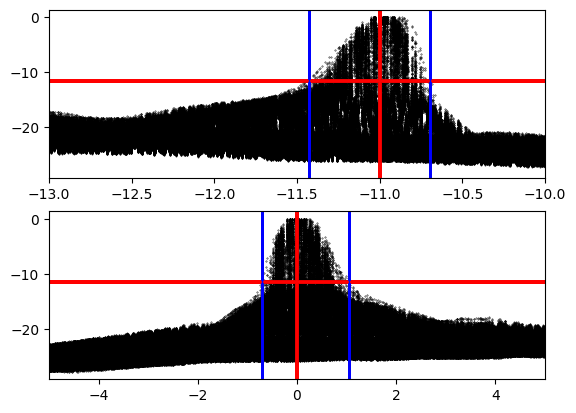

In [40]:
for i in tqdm.tqdm(range(100)):
    lrs = logratios_list_11[i]
    ax = plt.subplot(2, 1, 1)
    plt.scatter(lrs.params[::10, 0, 0], lrs.logratios[::10, 0] - torch.max(lrs.logratios[::10, 0]), s=0.1, c='k')
    plt.xlim(-13, -10)
    plt.axvline(-11, c="r")
    plt.axhline(np.log(1e-5), c='r')
    plt.axvline(cons_min_a_11, c='b', lw=1.0)
    plt.axvline(cons_max_a_11, c='b', lw=1.0)
    ax = plt.subplot(2, 1, 2)
    plt.scatter(lrs.params[::10, 0, 1], lrs.logratios[::10, 0] - torch.max(lrs.logratios[::10, 0]), s=0.1, c='k')
    plt.xlim(-5, 5)
    plt.axhline(np.log(1e-5), c='r')
    plt.axvline(0.0, c="r")
    plt.axvline(cons_min_g_11, c='b', lw=1.0)
    plt.axvline(cons_max_g_11, c='b', lw=1.0)

In [39]:
cons_min_a_11, cons_max_a_11, cons_min_g_11, cons_max_g_11

(-11.42961597442627,
 -10.696080207824707,
 -0.7066106200218201,
 1.0477334260940552)

100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


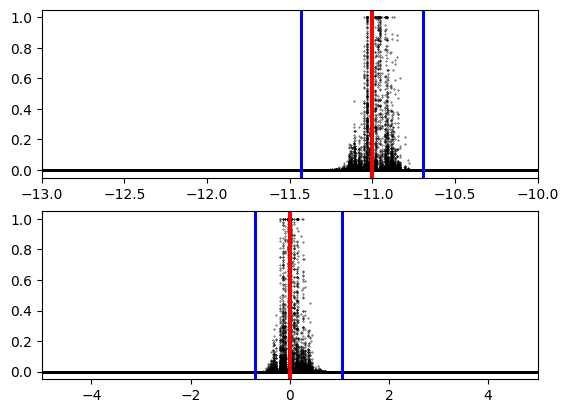

In [41]:
for i in tqdm.tqdm(range(100)):
    lrs = logratios_list_11[i]
    ax = plt.subplot(2, 1, 1)
    plt.scatter(lrs.params[::10, 0, 0], np.exp(lrs.logratios[::10, 0] - torch.max(lrs.logratios[::10, 0])), s=0.1, c='k')
    plt.xlim(-13, -10)
    plt.axvline(-11, c="r")
    #plt.axhline(np.log(1e-5), c='r')
    plt.axvline(cons_min_a_11, c='b', lw=1.0)
    plt.axvline(cons_max_a_11, c='b', lw=1.0)
    ax = plt.subplot(2, 1, 2)
    plt.scatter(lrs.params[::10, 0, 1], np.exp(lrs.logratios[::10, 0] - torch.max(lrs.logratios[::10, 0])), s=0.1, c='k')
    plt.xlim(-5, 5)
    #plt.axhline(np.log(1e-5), c='r')
    plt.axvline(0.0, c="r")
    plt.axvline(cons_min_g_11, c='b', lw=1.0)
    plt.axvline(cons_max_g_11, c='b', lw=1.0)

In [46]:
COV_DATA_DIR = "./simulations/"
COV_Z_FILES = glob.glob(COV_DATA_DIR + "/z_*.npy")
COV_Z_FILES = sorted(COV_Z_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
COV_DATA_FILES = glob.glob(COV_DATA_DIR + "/cg_data_*.npy")
COV_DATA_FILES = sorted(COV_DATA_FILES, key=lambda x: str(x.split("_")[-1].split(".")[0]))
cov_z_dataset = saqqara.NPYDataset(file_paths=COV_Z_FILES)
cov_data_dataset = saqqara.NPYDataset(file_paths=COV_DATA_FILES)
cov_training_dataset = saqqara.TrainingDataset(z_store=cov_z_dataset, data_store=cov_data_dataset)
coverage_train_dl, _ = setup_dataloaders(cov_training_dataset, total_size=1000, num_workers=10, batch_size=2000, train_fraction=1.0)
for batch in coverage_train_dl:
    z_arr = batch["z"]
    data_arr = batch["data"]
dm = swyft.Samples(z=z_arr, data=data_arr)

In [49]:
coverage_prior_samples = sim.sample(100_000, targets=['z'])
coverage_samples = trainer.test_coverage(network, dm, coverage_prior_samples)

100%|██████████| 100000/100000 [00:01<00:00, 80530.15it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 173.98it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 196000/196000 [27:42<00:00, 117.91it/s]


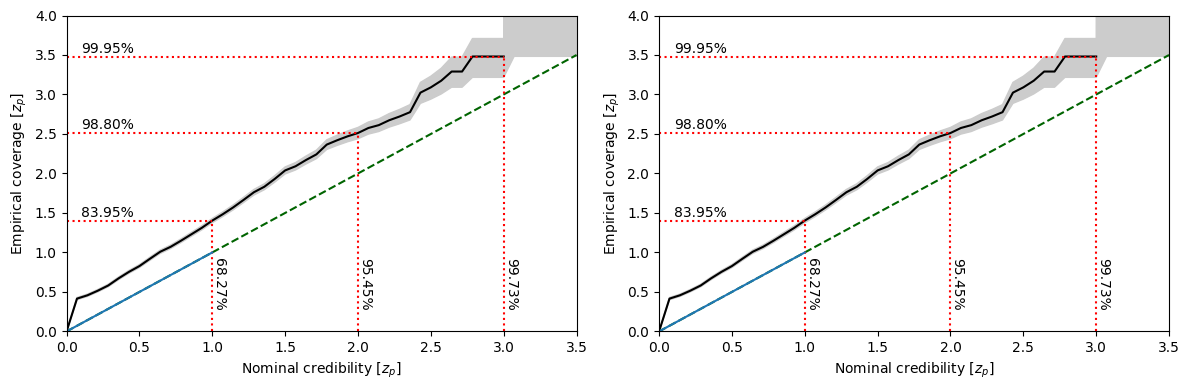

In [48]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

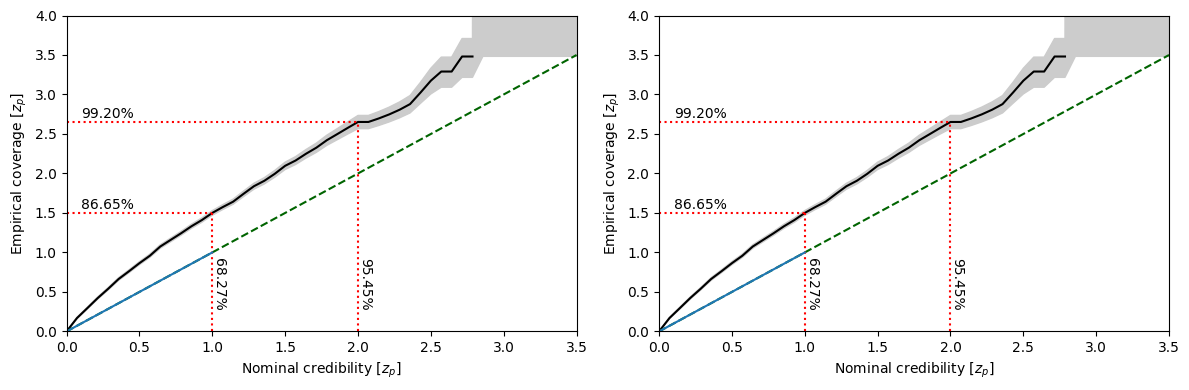

In [50]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

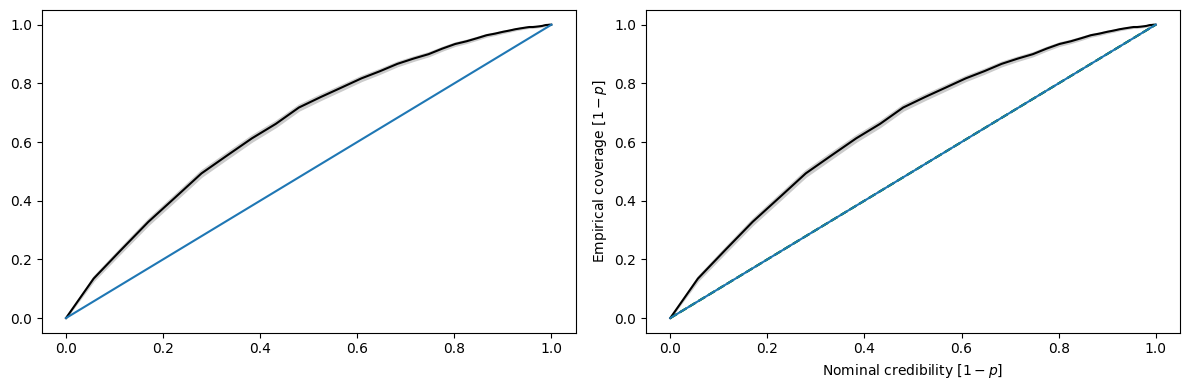

In [52]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()